In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/gimli/projects/igre


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from src.models.ig import information_gain as ig
import scipy.signal as sig
from sklearn.preprocessing import minmax_scale

In [3]:
def cvtData(line):
    data = line.strip().split(" ")
    while '' in data:
        data.remove('')
    return data

with open("/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/LamGods_Adoration_Lamb.ims", "rt", encoding="latin1") as imsfile:
    line = imsfile.readline()
    version = cvtData(line)[0]
    
    line = imsfile.readline()
    [width, height, depth] = cvtData(line)
    
    print("expected dimensions:", width, height, depth)
    
    matrix = np.zeros((int(width), int(height), int(depth)))

    all_data = []
    line = imsfile.readline()
    while line:
        all_data.extend(cvtData(line))
        try:
            line = imsfile.readline()
        except Exception as e:
            print(len(all_data))

expected dimensions: 134 126 227


In [25]:
imgs = np.asarray(all_data[:-227]).reshape(227, 126,134)

In [24]:
len(all_data[:-227])

3832668

In [26]:
# This legend is from Steven's excel

legend = [["scaling", "Hydrocerussite", "2PbCO3.Pb(OH)2", "775,63"],
["weightf", "Hydrocerussite", "2PbCO3.Pb(OH)2", "775,63"],
["scaling", "Cerussite", "PbCO3", "267,21"],
["weightf", "Cerussite", "PbCO3", "267,21"],
["scaling", "Lead tin yellow", "Pb2SnO4", "597,11"],
["weightf", "Lead tin yellow", "Pb2SnO4", "597,11"],
["scaling", "Cinnabar", "HgS", "232,67"],
["weightf", "Cinnabar", "HgS", "232,67"],
["scaling", "Calcite", "CaCO3", "100,09"],
["weightf", "Calcite", "CaCO3", "100,09"],
["scaling", "Posnjakite", "Cu4(SO4)(OH)6 · H2O", "470,31"],
["weightf", "Posnjakite", "Cu4(SO4)(OH)6 · H2O", "470,31"],
["scaling", "Gold", "Au", "196,97"],
["weightf", "Gold", "Au", "196,97"],
["scaling", "Zincite", "ZnO", "81,38"],
["weightf", "Zincite", "ZnO", "81,38"],
["scaling", "Goethite", "FeO(OH)", "88,85"],
["weightf", "Goethite", "FeO(OH)", "88,85"]]

In [29]:
# This bands were selected by Steven as relevant for the Lamb
lamb = imgs[[1, 2, 22, 23, 45, 46, 67, 68, 89, 90, 111, 112, 133, 134, 155, 156, 177, 178],:,:].astype(float);

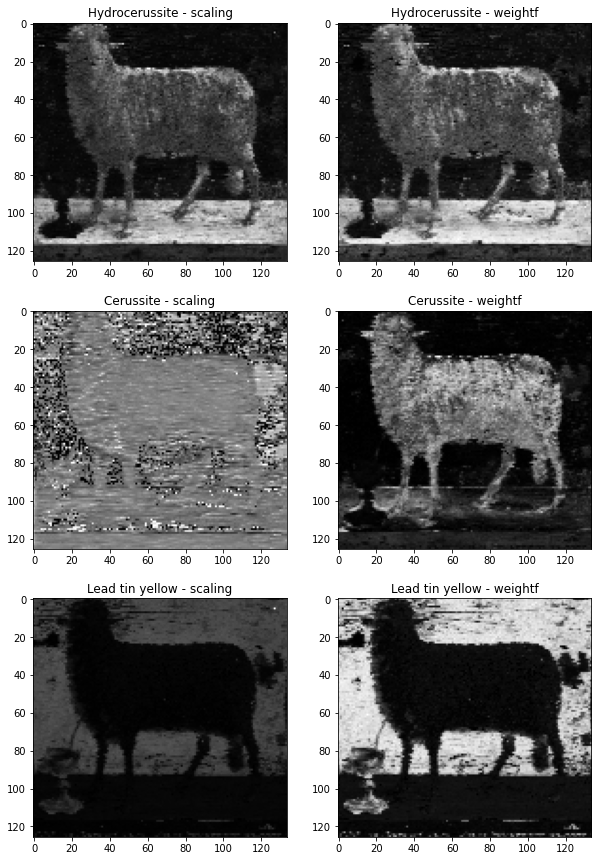

In [30]:
plt.figure(figsize=(10,15))
for i in np.arange(6):
    ax = plt.subplot(3,2,i+1)
    ax.imshow(np.flip(lamb[i,:,:],0), cmap='gray')
    ax.set_title(f"{legend[i][1]} - {legend[i][0]}")
plt.show()

In [31]:
# Creation of hypercube
xrpd = cv2.flip(lamb, flipCode=1)
xrpd = np.moveaxis(xrpd, 0, 2)

In [32]:
## Load registered data from Michal
xrf_folder='/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/registered-downsample'
files = os.listdir(xrf_folder)
xrf = np.zeros((xrpd.shape[0], xrpd.shape[1], len(files)))
for idx, file in enumerate(sorted(files)):
    xrf[:,:, idx] = cv2.cvtColor(cv2.imread(os.path.join(xrf_folder, file)),cv2.COLOR_BGR2GRAY)/255.0

In [10]:
# N(0,1) NORMALIZATION PRIMITIVES

In [11]:
# pd_avg = np.mean(xrpd.reshape((xrpd.shape[0] * xrpd.shape[1], xrpd.shape[2])), axis=0)
# pd_std = np.std(xrpd.reshape((xrpd.shape[0] * xrpd.shape[1], xrpd.shape[2])), axis=0)
# f_avg = np.mean(xrf.reshape((xrf.shape[0] * xrf.shape[1], xrf.shape[2])), axis=0)
# f_std = np.std(xrf.reshape((xrf.shape[0] * xrf.shape[1], xrf.shape[2])), axis=0)

In [12]:
# MIN - MAX NORMALIZATION

In [13]:
# XRPD data normalization

In [33]:
pd_norm = np.zeros(xrpd.shape)
for dim in range(xrpd.shape[2]):
    pd_norm[:,:,dim] = minmax_scale(xrpd[:,:,dim])

In [34]:
# XRF data normalization

In [35]:
f_norm = np.zeros(xrf.shape)
for dim in range(f_norm.shape[2]):
    f_norm[:,:,dim] = minmax_scale(xrf[:,:,dim].flatten()).reshape(xrf[:,:,dim].shape)

Training of transformation function:

f: **\[CuK, PbM, SnL\]** (XRF) -> **\[HydroCerrusite, Cerrusite, LeadTinYellow\]** bands in XRPD

In [36]:
for idx, file in enumerate(sorted(files)):
    print(f"{idx} - {file}")

0 - ArK.png
1 - AsK.png
2 - AuL.png
3 - AuM.png
4 - BaL.png
5 - BiL.png
6 - CaK.png
7 - ClK.png
8 - CoK.png
9 - Continuum.png
10 - CrK.png
11 - CuK.png
12 - FeK.png
13 - HgL.png
14 - HgM.png
15 - KK.png
16 - MnK.png
17 - NiK.png
18 - PbL.png
19 - PbM.png
20 - RhK.png
21 - RhL.png
22 - SK.png
23 - SnK.png
24 - SnL.png
25 - SrK.png
26 - TiK.png
27 - ZnK.png
28 - chisq.png


In [37]:
XRPD_DIMS = [1, 3, 5]
XRF_DIMS = [11,19,24]

# Mask integration
- train just on masked pixels

In [38]:
mask = cv2.imread('/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/downsampled-mask.png')[:,:,0]/255.0
mask[mask<0.5] = 0
mask[mask>=0.5]=1

In [39]:
[mgain, mapprox, mnet] = ig(f_norm[mask == 1][:,XRF_DIMS].reshape((np.sum(mask).astype(int), 1,len(XRF_DIMS))), 
                            pd_norm[mask==1][:,XRPD_DIMS].reshape((np.sum(mask).astype(int), 1,len(XRPD_DIMS))),
                           layers=[100,100,100,100])

Selecting 25000 samples randomly for use by algorithm.
Adding input layer, width = 3
Adding dense layer, width = 100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Adding dense layer, width = 100
Adding dense layer, width = 100
Adding dense layer, width = 100
Adding dense layer, width = 3
Compiling model took 0.0457's.
Train on 4344 samples, validate on 1086 samples
Epoch 1/300
4344/4344 [==============================] - 1s 128us/sample - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 2/300
4344/4344 [==============================] - 0s 85us/sample - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 3/300
4344/4344 [==============================] - 0s 88us/sample - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 4/300
4344/4344 [==============================] - 0s 97us/sample - loss: 0.0233 - mea

In [48]:
## Recompute for full-size image
approx = mnet.predict(f_norm[:,:,XRF_DIMS].reshape((f_norm.shape[0] * f_norm.shape[1], len(XRF_DIMS))))\
    .reshape((pd_norm.shape[0],pd_norm.shape[1],len(XRPD_DIMS)))
gain = pd_norm[:,:,XRPD_DIMS] - approx
# approx[0,0,:] = 0
# approx[-1,-1,:] = 1

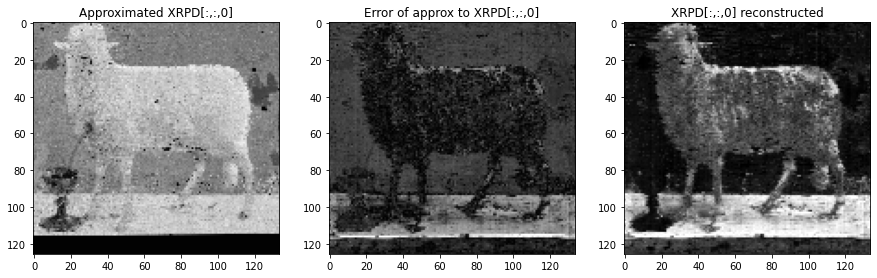

In [49]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow(approx[:,:,0], cmap='gray')
ax.set_title("Approximated XRPD[:,:,0]")

ax = plt.subplot(1,3,2)
ax.imshow(np.abs(gain[:,:,0]), cmap='gray')
ax.set_title("Error of approx to XRPD[:,:,0]")

ax = plt.subplot(1,3,3)
ax.imshow(approx[:,:,0] + gain[:,:,0], cmap='gray')
ax.set_title("XRPD[:,:,0] reconstructed")
plt.show()

In [50]:
np.min(approx[:,:,0] + gain[:,:,0])

0.0

In [195]:
# usage of the whole image - now ignored
# [gain, approx, net] = ig(f_norm[:115,:,XRF_DIMS], pd_norm[:115,:,XRPD_DIMS])

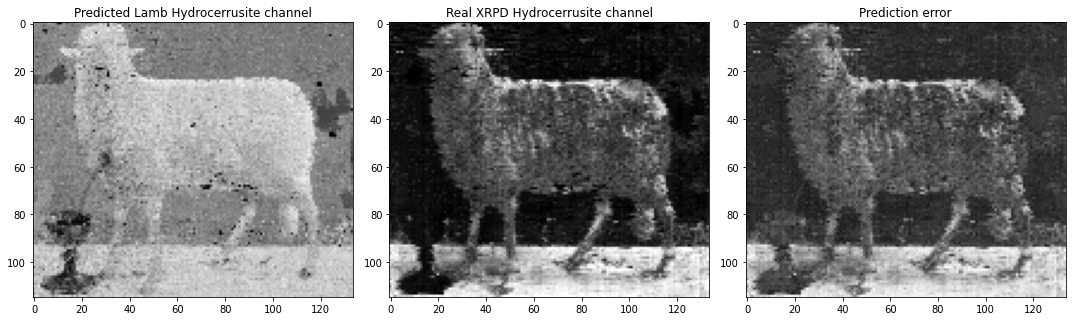

In [52]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.set_title("Predicted Lamb Hydrocerrusite channel")
ax.imshow(approx[:115,:,0], cmap="gray")
ax = plt.subplot(1,3,2)
ax.set_title("Real XRPD Hydrocerrusite channel")
ax.imshow(pd_norm[:115,:,1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.set_title("Prediction error")
ax.imshow(gain[:115,:,0], cmap="gray")
plt.tight_layout()
plt.show()

### Training on median filtered dataset
Section below is an attempt to use data without noise for trainint. This was not used in real processing. Therefore this section is commented out.

In [197]:
# f_med = np.zeros(f_norm.shape)
# for dim in range(f_med.shape[2]):
#     f_med[:,:,dim] = sig.medfilt(f_norm[:,:,dim], kernel_size=5)

In [198]:
# pd_med = np.zeros(pd_norm.shape)
# for dim in range(pd_med.shape[2]):
#     pd_med[:,:,dim] = sig.medfilt(pd_norm[:,:,dim], kernel_size=7)

In [199]:
# [gain, approx, net] = ig(f_med[:115,:,[9, 10]], pd_med[:115,:,[1,3,5]], layers=[100,100,100])

In [200]:
# plt.figure(figsize=(15,5))
# ax = plt.subplot(1,3,1)
# ax.set_title("Predicted Lamb Hydrocerrusite channel (median filter used before training)")
# ax.imshow(approx[:,:,0], cmap="gray")
# ax = plt.subplot(1,3,2)
# ax.set_title("Real XRPD Hydrocerrusite channel median filtered")
# ax.imshow(pd_med[:115,:,1], cmap="gray")
# ax = plt.subplot(1,3,3)
# ax.set_title("Prediction error")
# ax.imshow(gain[:,:,0], cmap="gray")
# plt.show()

In [201]:
# pd_predict = diff.predict(f_norm[:115,:,[9,10]].reshape((115*134,2))).reshape(115,134,3)

In [202]:
# plt.figure(figsize=(15,5))
# ax = plt.subplot(1,3,1)
# ax.imshow(pd_predict[:,:,0], cmap="gray")
# ax = plt.subplot(1,3,2)
# ax.imshow(pd_norm[:115,:,1], cmap="gray")
# ax = plt.subplot(1,3,3)
# ax.imshow(pd_predict[:,:,0]-pd_norm[:115,:,1], cmap="gray")
# plt.show()

In [203]:
# # Normalized XRPD - HC, C, LT
# plt.figure(figsize=(15,10))
# ax = plt.subplot(2,3,1)
# ax.imshow(pd_norm[:,:,1], cmap="gray")
# ax = plt.subplot(2,3,2)
# ax.imshow(pd_norm[:,:,3], cmap="gray")
# ax = plt.subplot(2,3,3)
# ax.imshow(pd_norm[:,:,5], cmap="gray")
# # Median filtered (the same)
# ax = plt.subplot(2,3,4)
# ax.imshow(pd_med[:,:,1], cmap="gray")
# ax = plt.subplot(2,3,5)
# ax.imshow(pd_med[:,:,3], cmap="gray")
# ax = plt.subplot(2,3,6)
# ax.imshow(pd_med[:,:,5], cmap="gray")
# plt.show()

In [204]:
# # Normalized XRF - PbL, PbM
# plt.figure(figsize=(15,10))
# ax = plt.subplot(2,3,1)
# ax.imshow(f_norm[:115,:,9], cmap="gray")
# ax = plt.subplot(2,3,2)
# ax.imshow(f_norm[:115,:,10], cmap="gray")
# ax = plt.subplot(2,3,4)
# ax.imshow(f_med[:115,:,9], cmap="gray")
# ax = plt.subplot(2,3,5)
# ax.imshow(f_med[:115,:,10], cmap="gray")
# plt.show()

## Linear modelling
In the section we tried to simmulate XRPD as a linear combination of PbL and PbM. Comparison of ANN and linalg approach is included

In [53]:
[coef, residua, _, _] = np.linalg.lstsq(f_norm[mask==1],
                                        pd_norm[mask==1][:, 1],rcond=None)

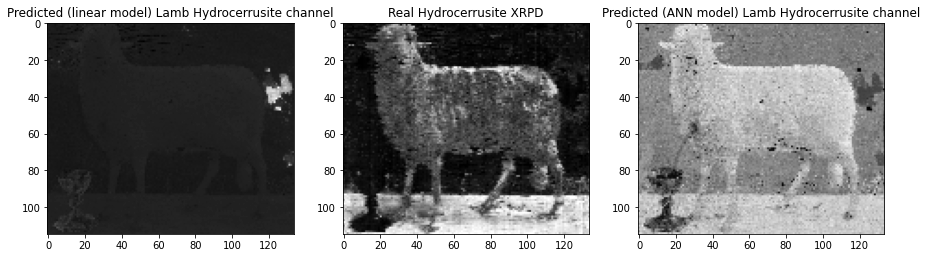

In [55]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.set_title("Predicted (linear model) Lamb Hydrocerrusite channel")
ax.imshow(np.matmul(f_norm[:115, :, :],coef).reshape(115,134), cmap="gray")
ax = plt.subplot(1,3,2)
ax.set_title("Real Hydrocerrusite XRPD")
ax.imshow(pd_norm[:115, :, 1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.set_title("Predicted (ANN model) Lamb Hydrocerrusite channel")
ax.imshow(approx[:115,:,0], cmap="gray")
plt.show()

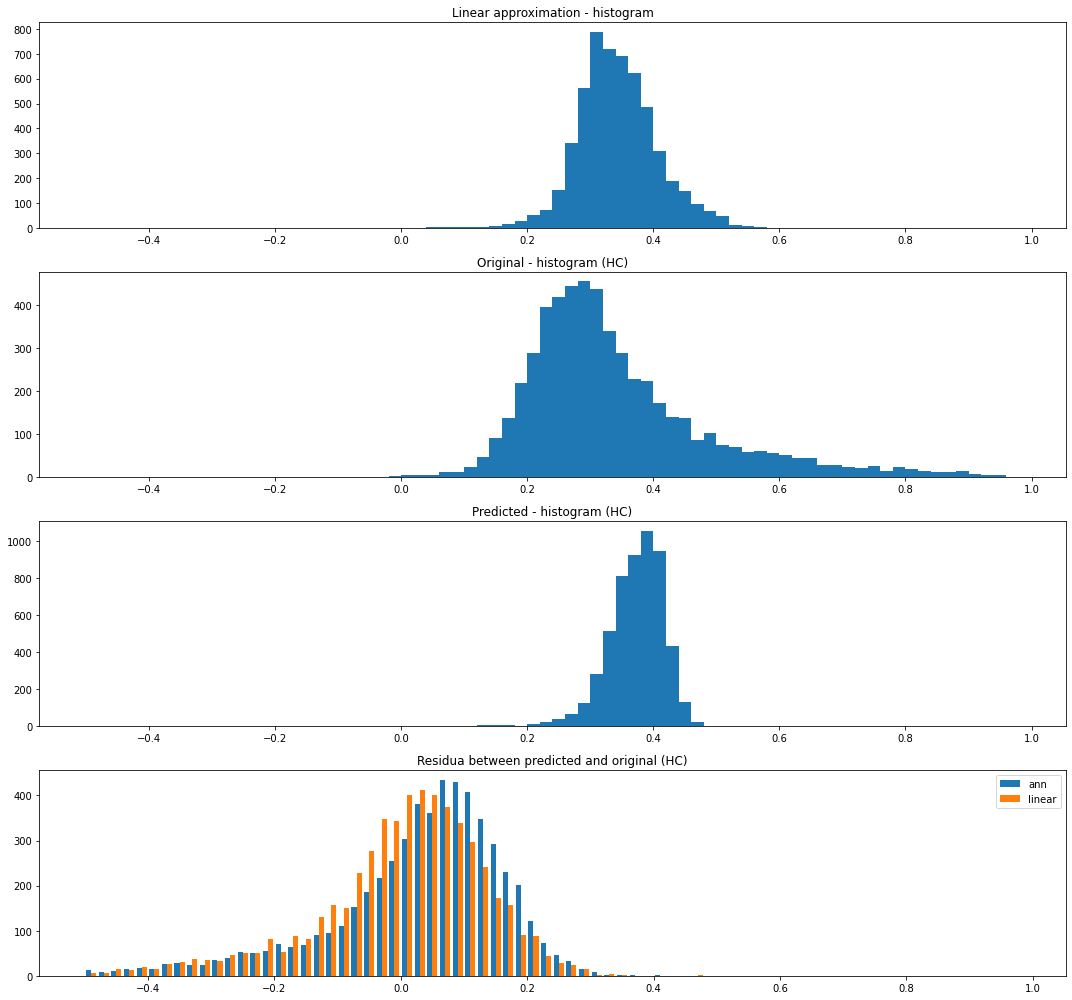

In [57]:
plt.figure(figsize=(15,14))
bins = np.arange(-0.5,1,0.02)
ax = plt.subplot(4,1,1)
ax.set_title("Linear approximation - histogram")
ax.hist(np.matmul(f_norm[mask==1],coef).flatten(), bins=bins)
ax = plt.subplot(4,1,2)
ax.set_title("Original - histogram (HC)")
ax.hist(pd_norm[mask==1][:,1].flatten(), bins=bins)
ax = plt.subplot(4,1,3)
ax.set_title("Predicted - histogram (HC)")
ax.hist(approx[mask==1][:,0].flatten(), bins=bins)
ax = plt.subplot(4,1,4)
ax.set_title("Residua between predicted and original (HC)")
ax.hist([(approx[mask==1][:,0]-pd_norm[mask==1][:,1]).flatten(), 
         (np.matmul(f_norm[mask==1],coef)-pd_norm[mask==1][:,1]).flatten()], 
        bins=bins, label=["ann", "linear"])
ax.legend()
plt.tight_layout()
plt.show()

In [58]:
# Correlation between approaches. We would like to have higher numbers for ANN approach (approx) 
# compared to linear model:
np.set_printoptions(2)
print(
np.corrcoef(np.moveaxis(
            np.concatenate([f_norm[:115, :, 11].reshape((115*134,1)),
                            f_norm[:115, :, 19].reshape((115*134,1)),
                            f_norm[:115, :, 24].reshape((115*134,1)),
                            pd_norm[:115, :, 1].reshape((115*134,1)),
                            np.matmul(f_norm[:115, :, :], coef).reshape((115*134,1)),
                            approx[:115,:,0].reshape((115*134,1))
                           ], axis=1),
    0, 1
)))
np.set_printoptions()

[[ 1.   -0.8   0.79 -0.66 -0.04 -0.6 ]
 [-0.8   1.   -0.71  0.74 -0.02  0.96]
 [ 0.79 -0.71  1.   -0.66 -0.31 -0.61]
 [-0.66  0.74 -0.66  1.    0.1   0.69]
 [-0.04 -0.02 -0.31  0.1   1.   -0.01]
 [-0.6   0.96 -0.61  0.69 -0.01  1.  ]]


# Registration matrix
- Matrix was produced in Slicer by @Michal Bartoš
- Here it is used for inverting residua to upscaled space. 
- Our approximation is then corrected by this upscaled residua.

In [59]:
# XRF to XRPD transformation matrix
Tij = [[0.1665, -3.8000e-05, -17.4220],[-4.8909e-04, 0.1787, -63.3877],[0,0,1]]

In [60]:
# XRPD to XRF transformation matrix
Tcv2 = np.float32(np.linalg.inv(Tij)[:2,:])

In [61]:
# XRF original data
pbxrf_folder='/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/xrf'
pbfiles = os.listdir(pbxrf_folder)
pbxrf = np.zeros((1000, 1000, len(pbfiles)), dtype=float)
for idx, file in enumerate(sorted(pbfiles)):
    pbxrf[:,:, idx] = cv2.cvtColor(cv2.imread(os.path.join(pbxrf_folder, file)),cv2.COLOR_BGR2GRAY)/255.0

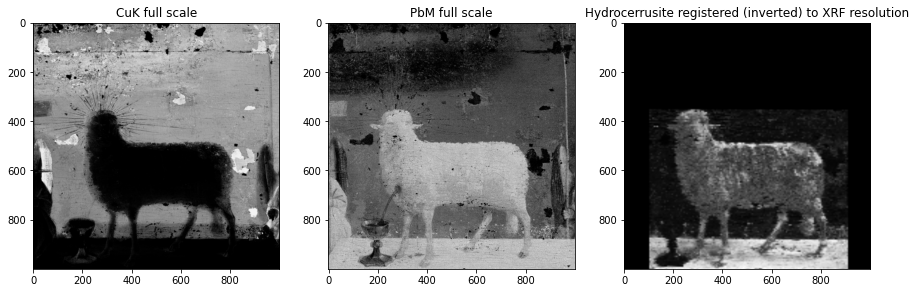

In [62]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.set_title("CuK full scale")
ax.imshow(pbxrf[:,:,11], cmap="gray")
ax = plt.subplot(1,3,2)
ax.set_title("PbM full scale")
ax.imshow(pbxrf[:,:,19], cmap="gray")
ax = plt.subplot(1,3,3)
ax.set_title("Hydrocerrusite registered (inverted) to XRF resolution")
ax.imshow(cv2.warpAffine(xrpd[:,:,1], Tcv2, (1000,1000)), cmap="gray")
plt.show()

## Usage of the model for SR
- trained network is used for producing upscaled version of XRPD
- input data must be normalized into N(0,1)
- output data are modified by adding min and max from original XRPD for correct visualization of relative intensities

In [63]:
pbxrf_norm = np.zeros(pbxrf.shape)

# DATA NORMALIZATION
for dim in range(pbxrf.shape[2]):
    pbxrf_norm[:,:,dim] = (pbxrf[:,:,dim] - np.min(pbxrf[356:,106:905,dim]))\
                          / (np.max(pbxrf[356:,106:905,dim]) - np.min(pbxrf[356:,106:905,dim]))
    
# UPSCALE
pd_up = mnet.predict(pbxrf_norm[:,:,XRF_DIMS].reshape(1000*1000,len(XRF_DIMS))).reshape(1000,1000,len(XRF_DIMS))

# RANGE PERSERVATION
# This way we preserve intensity in images.
# One value on the otherside does not have any statistical relevance (but must be ignored in evaluations).
pd_up[0,0,0] = np.min(pd_norm[:,:,1])
pd_up[-1,-1,0] = np.max(pd_norm[:,:,1])

In [64]:
pbxrf_norm.shape

(1000, 1000, 29)

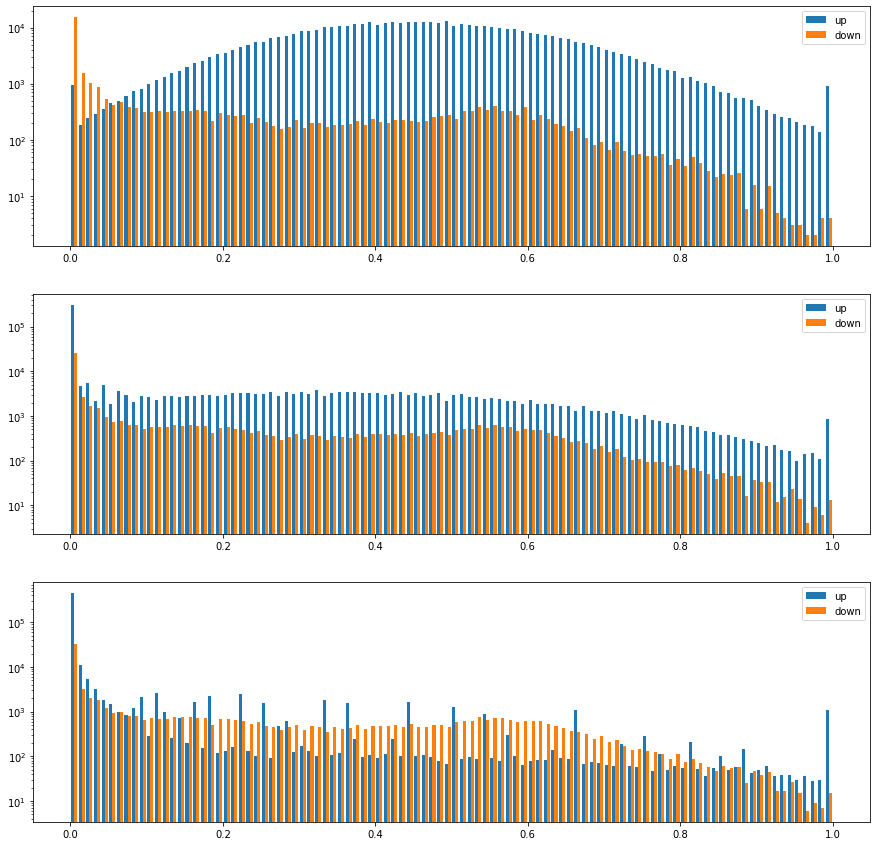

In [65]:
plt.figure(figsize=(15,15))
for dim in range(len(XRF_DIMS)):
    ax = plt.subplot(3,1,dim+1)
    nrm = minmax_scale(pbxrf[356:,106:905,dim])
    ax.hist([nrm, f_norm[:115,: XRF_DIMS[dim]]], label=["up", "down"], bins=100)
    ax.set_yscale("log")
    ax.legend()
plt.show()

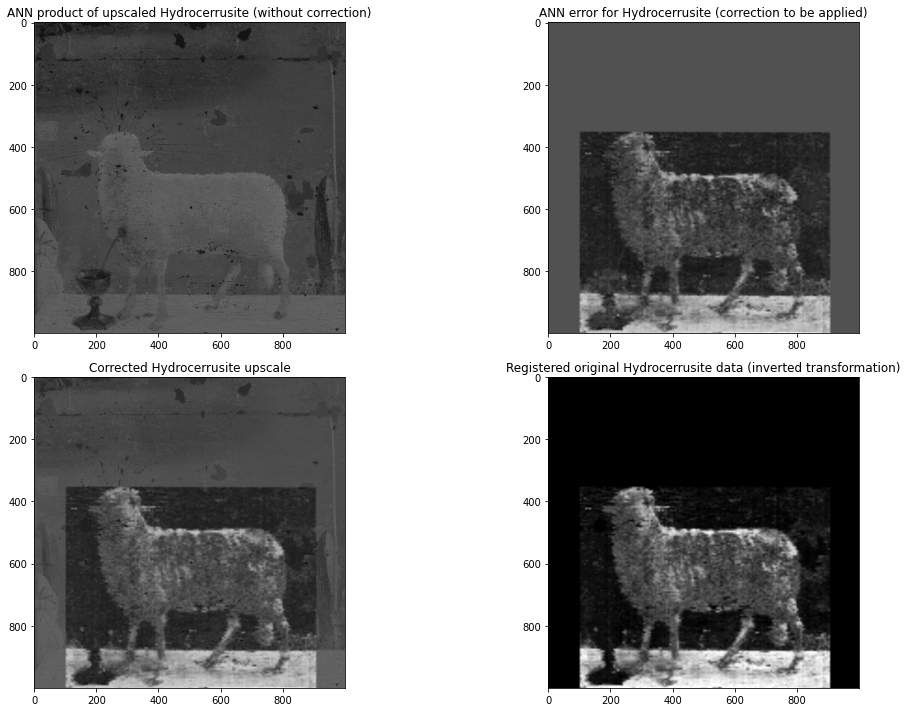

In [66]:
plt.figure(figsize=(15,10))
ax = plt.subplot(2,2,1)
ax.set_title("ANN product of upscaled Hydrocerrusite (without correction)")
ax.imshow(pd_up[:,:,0], cmap="gray")
ax = plt.subplot(2,2,2)
ax.set_title("ANN error for Hydrocerrusite (correction to be applied)")
ax.imshow(cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000)), cmap="gray")
ax = plt.subplot(2,2,3)
ax.set_title("Corrected Hydrocerrusite upscale")
ax.imshow(pd_up[:,:,0] + cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000)), cmap="gray")
ax = plt.subplot(2,2,4)
ax.set_title("Registered original Hydrocerrusite data (inverted transformation)")
ax.imshow(cv2.warpAffine(pd_norm[:,:,1], Tcv2, (1000,1000)), cmap="gray")
plt.tight_layout()
plt.show()

## Comparison of value distributions

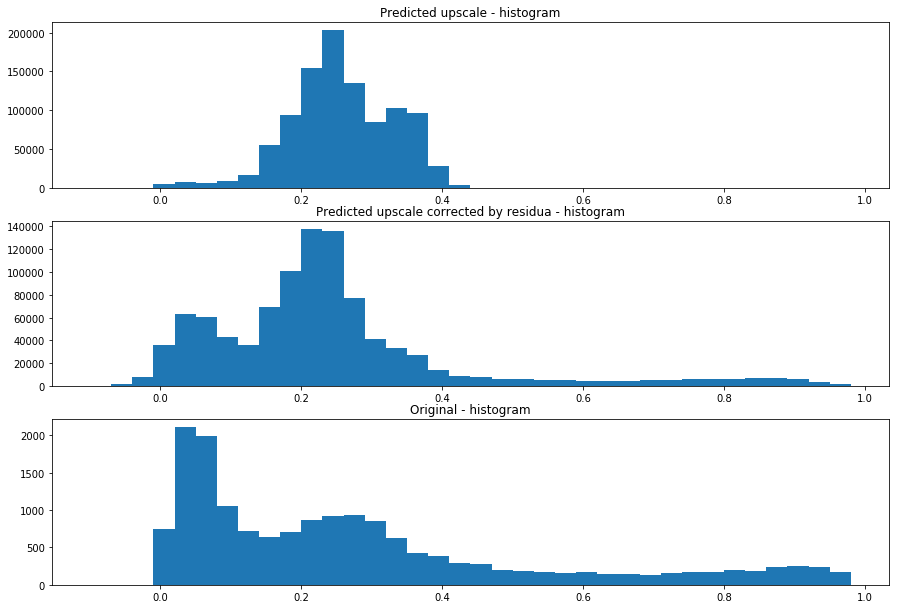

In [217]:
bins = np.arange(-0.1,1,0.03)

plt.figure(figsize=(15,14))
ax = plt.subplot(4,1,1)
ax.set_title("Predicted upscale - histogram")
ax.hist(pd_up[:,:,0].reshape(1000*1000,1), bins=bins)
ax = plt.subplot(4,1,2)
ax.set_title("Predicted upscale corrected by residua - histogram")
ax.hist((pd_up[:,:,0] + cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000))).reshape(1000*1000,1), bins=bins)
ax = plt.subplot(4,1,3)
ax.set_title("Original - histogram")
ax.hist(pd_norm[:,:,1].reshape(pd_norm.shape[0]*pd_norm.shape[1],1), bins=bins)
plt.show()

## Production of reports (images)
In the section below is necessary to setup properly which channel will be exported

In [234]:
xrpd_dim = 1 # one of [1, 3, 5]
pd_up_dim = 0 # one of [0, 1, 2]
filename_base = "hcII" # one of ["hc", "c", "lty"] hydrocerrusite, cerrusite, lead-tin yellow

In [235]:
pd_up_denorm = (pd_up[:,:,pd_up_dim] + cv2.warpAffine(gain[:,:,pd_up_dim], Tcv2, (1000,1000)))
pd_up_denorm[0,0] = 0
pd_up_denorm [-1,-1] = 1

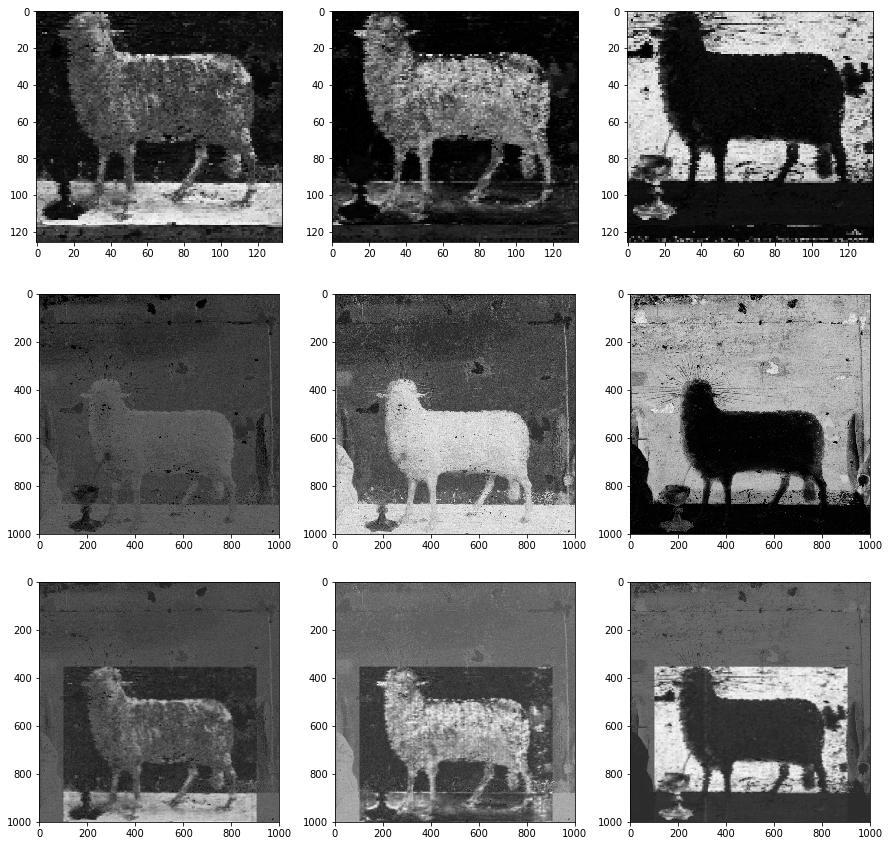

In [236]:
plt.figure(figsize=(15,15))
ax = plt.subplot(3,3,1)
ax.imshow(xrpd[:,:,1], cmap="gray")
ax = plt.subplot(3,3,2)
ax.imshow(xrpd[:,:,3], cmap="gray")
ax = plt.subplot(3,3,3)
ax.imshow(xrpd[:,:,5], cmap="gray")
ax = plt.subplot(3,3,4)
ax.imshow(pd_up[:,:,0], cmap="gray")
ax = plt.subplot(3,3,5)
ax.imshow(pd_up[:,:,1], cmap="gray")
ax = plt.subplot(3,3,6)
ax.imshow(pd_up[:,:,2], cmap="gray")
ax = plt.subplot(3,3,7)
ax.imshow((pd_up[:,:,0] + cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000))), cmap="gray")
ax = plt.subplot(3,3,8)
ax.imshow((pd_up[:,:,1] + cv2.warpAffine(gain[:,:,1], Tcv2, (1000,1000))), cmap="gray")
ax = plt.subplot(3,3,9)
ax.imshow((pd_up[:,:,2] + cv2.warpAffine(gain[:,:,2], Tcv2, (1000,1000))), cmap="gray")
plt.show()

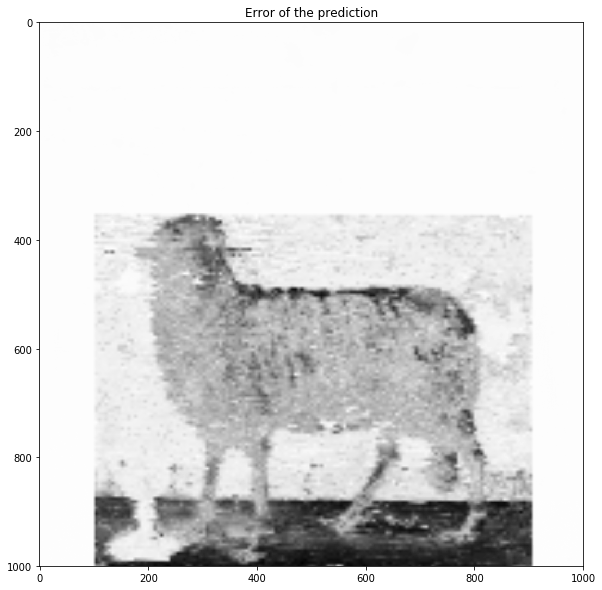

In [237]:
plt.figure(figsize=(10,10))
plt.imshow(
    pd_up_denorm - cv2.warpAffine(xrpd[:,:,xrpd_dim], Tcv2, (1000,1000)), 
    cmap="gray")
plt.title("Error of the prediction")
plt.show()

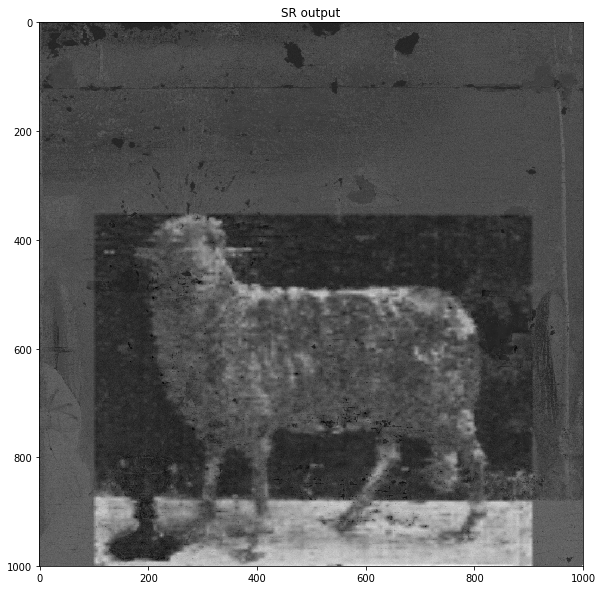

In [238]:
plt.figure(figsize=(10,10))
plt.imshow(pd_up_denorm, cmap="gray")
plt.title("SR output")
plt.show()

### Scale data to preserve original distribution

In [239]:
c_orig = cv2.warpAffine(xrpd[:,:,xrpd_dim], Tcv2, (1000,1000))
c_write = (c_orig - np.min(c_orig)) / (np.max(c_orig) - np.min(c_orig)) * 255

cv2.imwrite(f'/Users/gimli/Qsync/datasets/Gent-Altairpiece/{filename_base}.png', c_write)

True

In [240]:
cv2.imwrite(f'/Users/gimli/Qsync/datasets/Gent-Altairpiece/{filename_base}up.png', 
            pd_up_denorm*255)

True

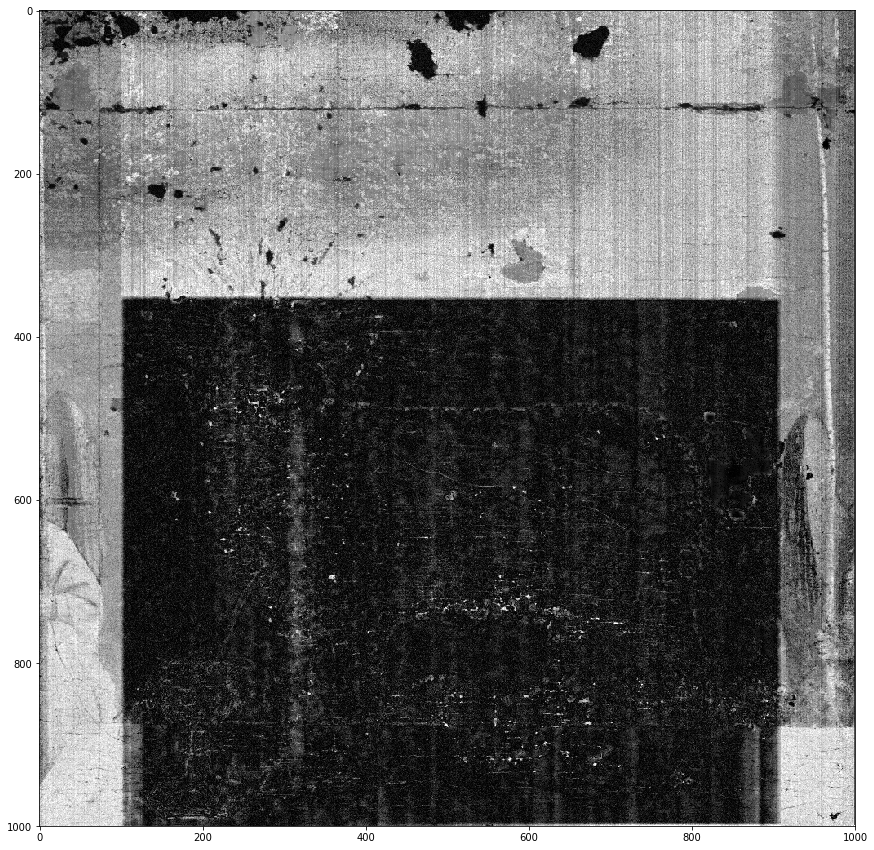

In [241]:
plt.figure(figsize=(15,15))
plt.imshow(minmax_scale(np.abs(pd_up_denorm-c_write/255)), cmap='gray')
plt.show()

## Testing of ANN limitations
- it seems that there is maximum and minimum of y_exp limitted??

In [ ]:
ins = np.random.random_sample((100,100,1))
ous = ins * 1000

[g, a, n] = ig(ins,ous)

In [ ]:
plt.figure(figsize=(15,10))
ax = plt.subplot(3,1,1)
h1 = ax.hist(a.reshape(10000,1), bins=np.arange(0,1000,1))
ax = plt.subplot(3,1,2)
h2 = ax.hist(ins.reshape(10000,1)*1000, bins=np.arange(0,1000,1))
ax = plt.subplot(3,1,3)
ax.plot((h1[0]-h2[0]).tolist())
plt.show()

In [ ]:
n.layers[-1].get_weights()